In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
DIRECTORY = 'drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_02/'

In [ ]:
! cp drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_02/layers.py layers.py

## Семинар 2 "Распознавание рукописных цифр"

ФИО: Иванов Максим Юрьевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [ ]:
import torch

torch.__version__

'1.8.1+cu101'

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork  # Results from Seminar 1
%matplotlib inline
from IPython.display import clear_output
from tqdm.notebook import tqdm

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
def get_datasets(download=False, transform=None, test=True):
    transform = transform or transforms.Compose([                     
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = MNIST('.', train=True, download=download, transform=transform)
    if test:
        test_dataset = MNIST('.', train=False, transform=transform)

    return train_dataset, test_dataset if test else train_dataset

In [ ]:
def get_loaders(download=False, new_transform=None):
    train_dataset, test_dataset = get_datasets(download)

    if new_transform:
        new_train_dataset = get_datasets(download=True, transform=new_transform, test=False)
        train_dataset = train_dataset + new_train_dataset

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

    return train_loader, test_loader

In [ ]:
base_train_loader, base_test_loader = get_loaders(download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [ ]:
## Usage example:
for X, y in base_train_loader:
    X = np.asarray(list(map(lambda x: x.view(x.shape[0], -1).numpy() if not isinstance(x, tuple) else x[0].view(x[0].shape[0], -1).numpy(), X))).reshape((-1, 784))
    y = np.asarray(list(map(lambda x: x if not isinstance(x, tuple) else x[1], y)))
    #X = X.view(X.shape[0], -1)
    #X = X.numpy() ### Converts torch.Tensor to numpy array
    #y = y.numpy()

    assert X.shape == (32, 784)
    assert y.shape == (32, )

    #print(X.shape)
    #print(y.shape)
print("All is OK")

All is OK


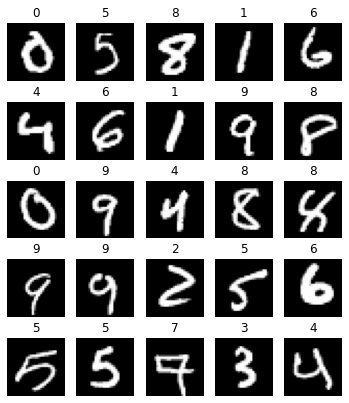

In [ ]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [ ]:
def train(network, train_loader=None, test_loader=None, epochs=10, learning_rate=0.01, plot=True,
          verbose=True, loss=None, clear_data=True):
    
    train_loader = train_loader or base_train_loader
    test_loader = test_loader or base_test_loader
    loss = loss or NLLLoss()

    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []

    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                if len(y) != 32:
                    continue
                X = np.asarray(list(map(lambda x: x.view(x.shape[0], -1).numpy() if not isinstance(x, tuple) else x[0].view(x[0].shape[0], -1).numpy(), X))).reshape((-1, 784))
                y = np.asarray(list(map(lambda x: x if not isinstance(x, tuple) else x[1], y)))
                #X = X.view(X.shape[0], -1).numpy()
                #y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1) == y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = np.asarray(list(map(lambda x: x.view(x.shape[0], -1).numpy(), X))).reshape((-1, 784))
                y = np.asarray(list(map(lambda x: x if not isinstance(x, tuple) else x[1], y)))
                #X = X.view(X.shape[0], -1).numpy()
                #y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1) == y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            
            if verbose:
                if clear_data:
                    clear_output(True)
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}\n'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [ ]:
def get_nn(activation_name='Sigmoid'):
    if activation_name == 'Sigmoid':
        activation = Sigmoid
    elif activation_name == 'ReLU':
        activation = ReLU
    elif activation_name == 'ELU':
        activation = ELU
    elif activation_name == 'TanH':
        activation = TanH
    layers = [
        Linear(784, 100), activation(),
        Linear(100, 100), activation(),
        Linear(100, 10)
    ]
    network = NeuralNetwork(layers)
    return network

In [ ]:
train_loss = {}
test_loss = {}
train_accuracy = {}
test_accuracy = {}
networks = {}

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

Epoch 19... (Train/Test) NLL: 0.330/0.326	Accuracy: 0.914/0.915


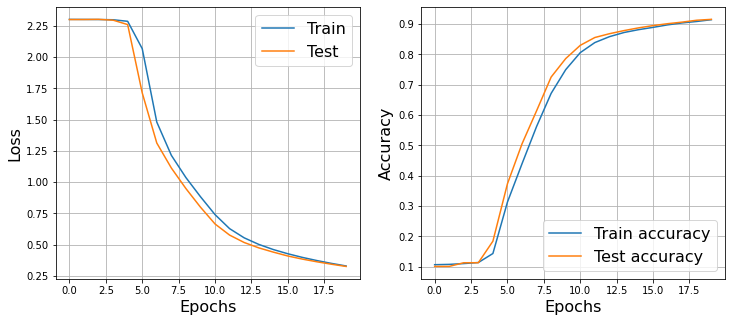

CPU times: user 8min 19s, sys: 5min 46s, total: 14min 5s
Wall time: 7min 15s


In [ ]:
%%time
act = 'Sigmoid'
name = act
networks[name] = get_nn(act)
train_loss[name], test_loss[name], train_accuracy[name], test_accuracy[name] = train(networks[name])

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [ ]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.035/0.078	Accuracy: 0.991/0.976

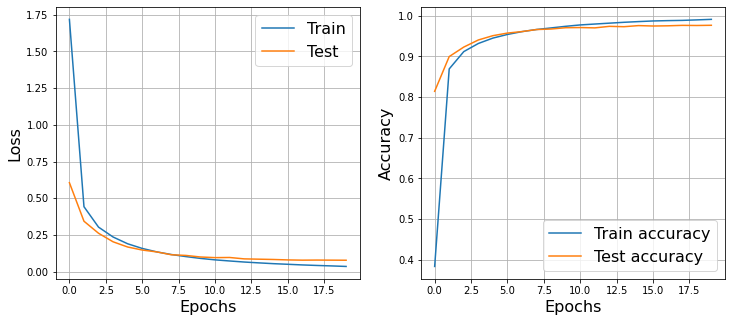

CPU times: user 8min 6s, sys: 5min 33s, total: 13min 40s
Wall time: 7min 3s


In [ ]:
%%time
act = 'ReLU'
name = act
networks[name] = get_nn(act)
train_loss[name], test_loss[name], train_accuracy[name], test_accuracy[name] = train(networks[name])

In [ ]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.046/0.079	Accuracy: 0.987/0.976

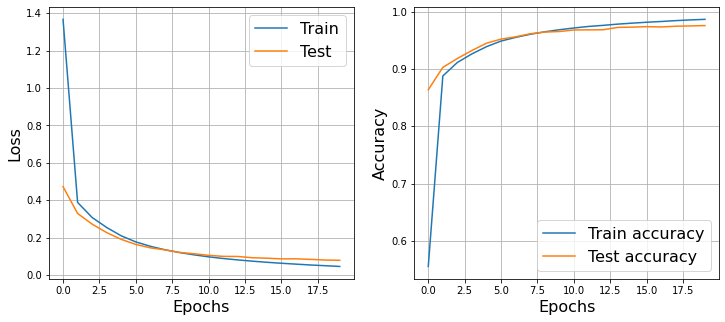

CPU times: user 8min 43s, sys: 6min 4s, total: 14min 48s
Wall time: 7min 39s


In [ ]:
%%time
act = 'ELU'
name = act
networks[name] = get_nn(act)
train_loss[name], test_loss[name], train_accuracy[name], test_accuracy[name] = train(networks[name])

In [ ]:
def plot_comp(test_loss, test_accuracy, activation_start='', activation_end=''):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    for act in test_loss:
        if act.startswith(activation_start) and act.endswith(activation_end):
            plt.plot(test_loss[act], label=act)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    for act in test_accuracy:
        if act.startswith(activation_start) and act.endswith(activation_end):
            plt.plot(test_accuracy[act], label=act)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid()
    plt.show()

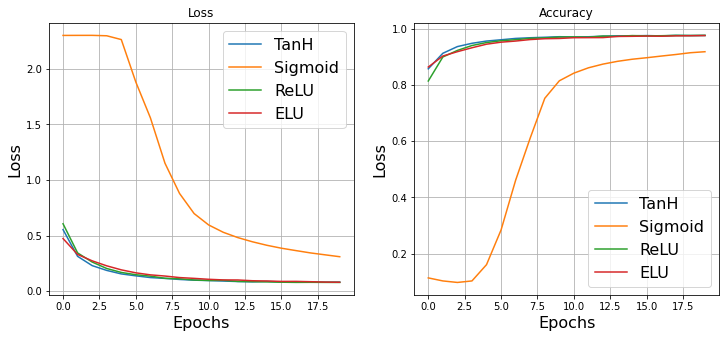

In [ ]:
plot_comp(test_loss, test_accuracy)

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

In [ ]:
def plot_analysis(act):
    wrong_X = []
    correct_y = []
    predicted_y = []
    logits = []
    for X, y in test_loader:
        X = X.view(X.shape[0], -1).numpy()
        y = y.numpy()
        prediction = networks[act].forward(X)
        prediction = np.exp(prediction)
        prediction /= prediction.sum(1, keepdims=True)
        for i in range(len(prediction)):
            if np.argmax(prediction[i]) != y[i]:
                wrong_X.append(X[i])
                correct_y.append(y[i])
                predicted_y.append(np.argmax(prediction[i]))
                logits.append(prediction[i][y[i]])
    wrong_X = np.row_stack(wrong_X)
    correct_y = np.row_stack(correct_y)[:, 0]
    predicted_y = np.row_stack(predicted_y)[:, 0]
    logits = np.row_stack(logits)[:, 0]

    plt.figure(figsize=(10, 5))
    order = np.argsort(logits)
    for i in range(21):
        plt.subplot(3, 7, i+1)
        plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
        plt.axis('off')

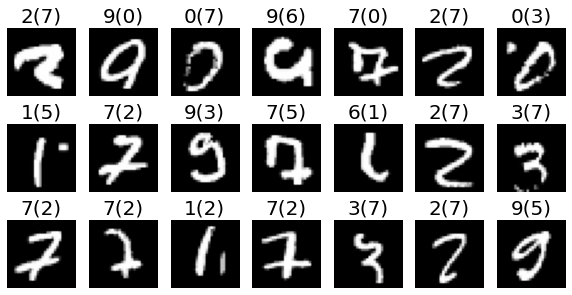

In [ ]:
plot_analysis('Sigmoid')

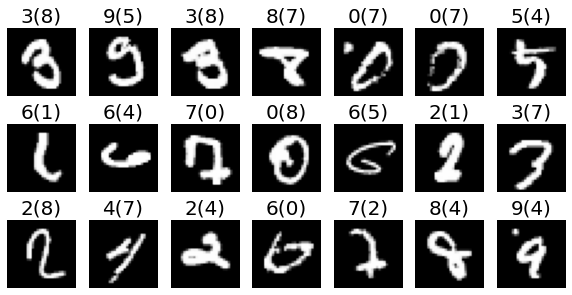

In [ ]:
plot_analysis('ReLU')

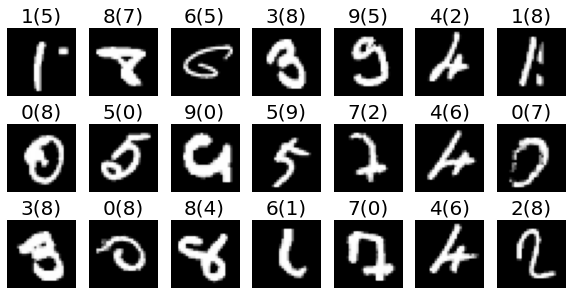

In [ ]:
plot_analysis('ELU')

### HW1 (1 балл): Реализовать Tanh

In [ ]:
class TanH:
    '''
    TanH(x) = ( e^x - e^(-x) ) / ( e^x + e^(-x) )
    '''
    
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return ( np.exp(X) - np.exp(-X) ) / ( np.exp(X) + np.exp(-X) )
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = 1 - (( np.exp(X) - np.exp(-X) ) / ( np.exp(X) + np.exp(-X) )) ** 2
        return dLdy * dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.030/0.081	Accuracy: 0.994/0.976

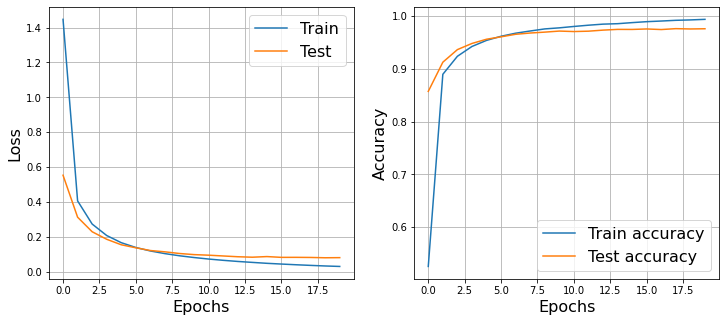

CPU times: user 9min 42s, sys: 6min 52s, total: 16min 34s
Wall time: 8min 33s


In [ ]:
%%time
act = 'TanH'
name = act
networks[name] = get_nn(act)
train_loss[name], test_loss[name], train_accuracy[name], test_accuracy[name] = train(networks[name])

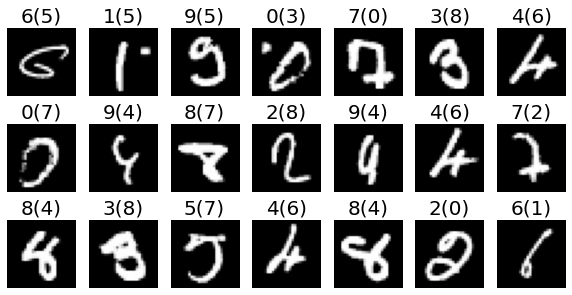

In [ ]:
plot_analysis('TanH')

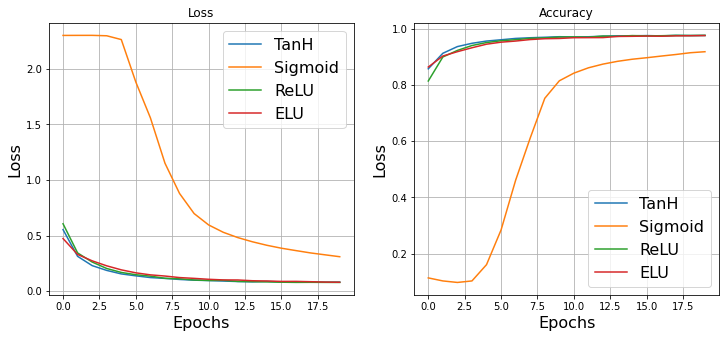

In [ ]:
plot_comp(test_loss, test_accuracy)

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [ ]:
def get_aug_loaders(rotate=False, shift=False, noise=False, all=False):
    transform = []
    if rotate or all:
        transform.append(transforms.RandomAffine(15))
    if shift or all:
        transform.append(transforms.RandomAffine(0, (0.1, 0.1)))
    
    transform.append(transforms.ToTensor())

    # Шум слишком большой, нужно проверить данные визуально и посмотреть,
    # не портит ли аугментация данные
    if noise or all:
        transform.append(transforms.Lambda(lambda x: x + torch.randn_like(x)))
    
    transform.append(transforms.Normalize((0.1307,), (0.3081,)))

    transform = transforms.Compose(transform)
    return get_loaders(new_transform=transform)

In [ ]:
check_train_loader, check_test_loader = get_aug_loaders(all=True)
for X, y in check_train_loader:
    if len(y) != 32:
        print("ERROR LEN:", len(y))
        continue
    X = np.asarray(list(map(lambda x: x.view(x.shape[0], -1).numpy() if not isinstance(x, tuple) else x[0].view(x[0].shape[0], -1).numpy(), X))).reshape((-1, 784))
    y = np.asarray(list(map(lambda x: x if not isinstance(x, tuple) else x[1], y)))
    #X = X.view(X.shape[0], -1)
    #X = X.numpy() ### Converts torch.Tensor to numpy array
    #y = y.numpy()

    try:
        assert X.shape == (32, 784)
        assert y.shape == (32, )
    except Exception:
        print(X.shape)
        print(y.shape)
        print(X)
        print(y)

    # print(X.shape)
    # print(y.shape)
    # break
print("All is OK")

ERROR LEN: 2
All is OK


In [ ]:
loaders = {
    'base': (base_train_loader, base_test_loader),
    'rotate': get_aug_loaders(rotate=True),
    'shift': get_aug_loaders(shift=True),
    'noise': get_aug_loaders(noise=True),
    'all': get_aug_loaders(all=True),
}

In [ ]:
activations = ['Sigmoid', 'ReLU', 'ELU', 'TanH']

In [ ]:
%%time
epochs = 10
for act in activations:
    for loader_name, (train_loader, test_loader) in loaders.items():
        name = act + '_' + loader_name
        print(name)
        networks[name] = get_nn(act)
        train_loss[name], test_loss[name], train_accuracy[name], test_accuracy[name] = train(networks[name], train_loader=train_loader, test_loader=test_loader, epochs=epochs, clear_data=False)

Output hidden; open in https://colab.research.google.com to view.

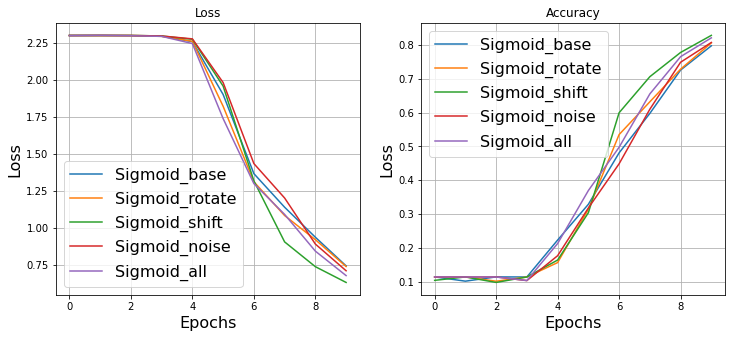

In [ ]:
plot_comp(test_loss, test_accuracy, 'Sigmoid')

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

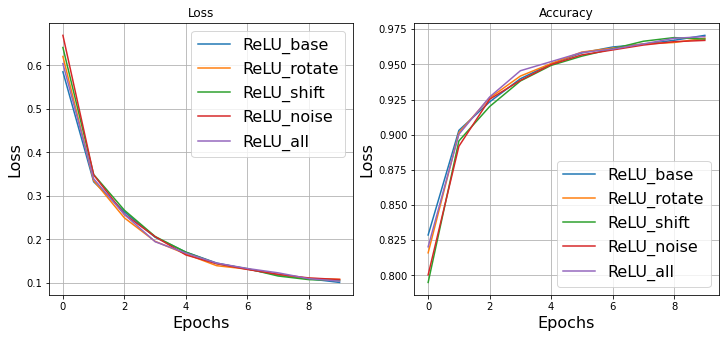

In [ ]:
plot_comp(test_loss, test_accuracy, 'ReLU')

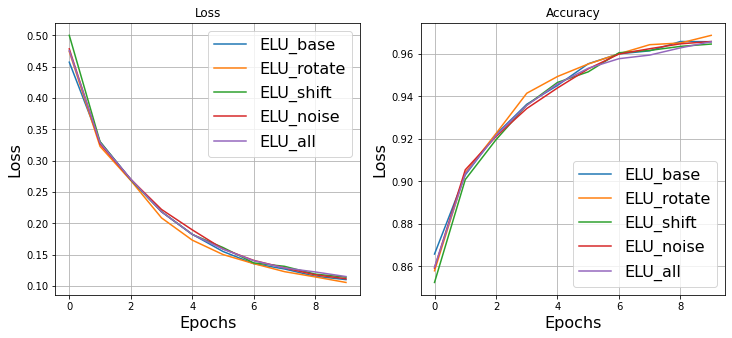

In [ ]:
plot_comp(test_loss, test_accuracy, 'ELU')

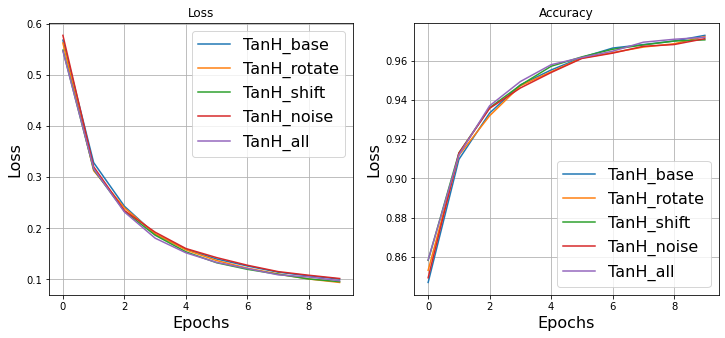

In [ ]:
plot_comp(test_loss, test_accuracy, 'TanH')

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Sigmoid сходится гораздо медленнее, чем ReLU, ELU и TanH.

Аугментация данных не сильно влияет на итоговое качество в данной задаче.